# Analyze diversity of clone barcode (library with viral index 1)

This notebook and the corresponding notebook for viral index 2 must be run before "barcode_diversity.ipynb" to generate the preprocessed data that is used in the latter notebook.

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
import gzip
from Bio import SeqIO
import logomaker

## Set output parameters

In [3]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/barcode_diversity_library1"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [4]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load sequencing reads

In [5]:
%%time

# Load read 1
# Note: We do not analyze read 2. The reads are longer than the insert, so read 2 is redundant.

infile = "/scratch/CellFreeReporter/seq/211108_M05340_0290_000000000-JK7T9/sFH2/sFH2_S2_L001_R1_001.fastq.gz"  # path to raw sequencing reads (read 1)

ids = []
seqs = []

with gzip.open(infile, "rt") as handle:
    
    for record in SeqIO.parse(handle, "fastq"):

        ids.append(record.id)
        seqs.append(str(record.seq))

reads = pd.DataFrame(data={"id": ids, "seq_raw_r1": seqs})

print(reads.shape)
reads.head()

(2779470, 2)
CPU times: user 1min 50s, sys: 2.81 s, total: 1min 53s
Wall time: 1min 53s


,id,seq_raw_r1
0,M05340:290:000000000-JK7T9:1:1101:20670:1694,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCTCTGTGTCACT...
1,M05340:290:000000000-JK7T9:1:1101:18704:1719,TGCGCGTGTGACCTGTACACGTACGGCTTGTCACTAATCTTGCGGC...
2,M05340:290:000000000-JK7T9:1:1101:12907:1719,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCAGACACTGTGA...
3,M05340:290:000000000-JK7T9:1:1101:14133:1730,TTCCGTTACCTTGTTTCTGAGCGGCGCGCCCATCCTCTCTCAGTGT...
4,M05340:290:000000000-JK7T9:1:1101:8821:1731,TGCGCGGGTGACCTGTACACGTACGGCTTGTAACTAATCTTGCGGC...


# Preprocess data

In [6]:
# Define function to reverse complement DNA

def reverse_complement(s):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N': 'N'}
    return ''.join([complement[base] for base in s[::-1]])

## Find flanking sequences within reads

In [7]:
# Specify anchor sequences, which flank barcode

SEQ_FLANKING_BC_5P = "GCGGCGCGCC"  # 5' of BC in reference direction (encompassing 2 bp + SgsI)
SEQ_FLANKING_BC_3P = "GCGGCCGCAA"  # 3' of BC in reference direction (encompassing NotI + 2 bp)

SEQ_FLANKING_BC_5P_RC = reverse_complement(SEQ_FLANKING_BC_5P)
SEQ_FLANKING_BC_3P_RC = reverse_complement(SEQ_FLANKING_BC_3P)

In [8]:
# Find index of flanking sequence within read
reads["index_r1_seq_flanking_bc_5p"] = reads["seq_raw_r1"].str.find(SEQ_FLANKING_BC_5P)
reads["index_r1_seq_flanking_bc_3p"] = reads["seq_raw_r1"].str.find(SEQ_FLANKING_BC_3P)
reads["index_r1_seq_flanking_bc_5p_rc"] = reads["seq_raw_r1"].str.find(SEQ_FLANKING_BC_5P_RC)
reads["index_r1_seq_flanking_bc_3p_rc"] = reads["seq_raw_r1"].str.find(SEQ_FLANKING_BC_3P_RC)

In [9]:
# Set flags for match to flanking sequence in forward or reverse orientations
reads["r1_flanking_hit_forward"] = (reads["index_r1_seq_flanking_bc_5p"] >= 0) & (reads["index_r1_seq_flanking_bc_3p"] >= 0)
reads["r1_flanking_hit_reverse"] = (reads["index_r1_seq_flanking_bc_5p_rc"] >= 0) & (reads["index_r1_seq_flanking_bc_3p_rc"] >= 0)

## Extract barcode

In [10]:
# Initialize all reads with empty barcode

reads["barcode"] = np.nan

In [11]:
# Get barcodes in forward orientation

reads_subset = reads.loc[reads["r1_flanking_hit_forward"] == True]  # get subset of reads with flanking sequence hit in Read 1

# Slice sequence to get barcode sequence

barcodes_r1 = []

for seq, index_r1_seq_flanking_bc_5p, index_r1_seq_flanking_bc_3p in zip(reads_subset["seq_raw_r1"],
                                                                               reads_subset["index_r1_seq_flanking_bc_5p"],
                                                                               reads_subset["index_r1_seq_flanking_bc_3p"]):
    
    start_index = index_r1_seq_flanking_bc_5p + len(SEQ_FLANKING_BC_5P)
    stop_index = index_r1_seq_flanking_bc_3p
    barcode = seq[start_index:stop_index]
    
    barcodes_r1.append(barcode)

reads.loc[reads["r1_flanking_hit_forward"] == True, "barcode"] = barcodes_r1

In [12]:
# Get barcodes in reverse orientation

reads_subset = reads.loc[reads["r1_flanking_hit_reverse"] == True]  # get subset of reads with flanking sequence hit in Read 1

# Slice sequence to get barcode sequence

barcodes_r1 = []

for seq, index_r1_seq_flanking_bc_5p_rc, index_r1_seq_flanking_bc_3p_rc in zip(reads_subset["seq_raw_r1"],
                                                                               reads_subset["index_r1_seq_flanking_bc_5p_rc"],
                                                                               reads_subset["index_r1_seq_flanking_bc_3p_rc"]):
    
    start_index = index_r1_seq_flanking_bc_3p_rc + len(SEQ_FLANKING_BC_3P_RC)
    stop_index = index_r1_seq_flanking_bc_5p_rc
    
    barcode_rc = seq[start_index:stop_index]
    barcode = reverse_complement(barcode_rc)
    
    barcodes_r1.append(barcode)

reads.loc[reads["r1_flanking_hit_reverse"] == True, "barcode"] = barcodes_r1

## Filter to remove reads with anomalously short barcodes (rare)

In [13]:
# Check how many reads with short barcodes are present
reads_subset = reads.loc[reads["barcode"] == ""]
print(reads_subset.shape)
reads_subset.head()

(0, 9)


,id,seq_raw_r1,index_r1_seq_flanking_bc_5p,index_r1_seq_flanking_bc_3p,index_r1_seq_flanking_bc_5p_rc,index_r1_seq_flanking_bc_3p_rc,r1_flanking_hit_forward,r1_flanking_hit_reverse,barcode


In [14]:
reads_temp = reads.loc[reads["barcode"] != ""]
print(reads_temp.shape)
reads_temp.head()

(2779470, 9)


,id,seq_raw_r1,index_r1_seq_flanking_bc_5p,index_r1_seq_flanking_bc_3p,index_r1_seq_flanking_bc_5p_rc,index_r1_seq_flanking_bc_3p_rc,r1_flanking_hit_forward,r1_flanking_hit_reverse,barcode
0,M05340:290:000000000-JK7T9:1:1101:20670:1694,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCTCTGTGTCACT...,20,62,-1,-1,True,False,CATCCTCTGTGTCACTCTCTCTCACTGTGTCT
1,M05340:290:000000000-JK7T9:1:1101:18704:1719,TGCGCGTGTGACCTGTACACGTACGGCTTGTCACTAATCTTGCGGC...,-1,-1,81,39,False,True,CATCCACTCACAGACACAGACACACACACTGA
2,M05340:290:000000000-JK7T9:1:1101:12907:1719,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCAGACACTGTGA...,20,62,-1,-1,True,False,CATCCAGACACTGTGAGACACTCAGTCACACT
3,M05340:290:000000000-JK7T9:1:1101:14133:1730,TTCCGTTACCTTGTTTCTGAGCGGCGCGCCCATCCTCTCTCAGTGT...,20,62,-1,-1,True,False,CATCCTCTCTCAGTGTCTGTCTCTGTCTGACT
4,M05340:290:000000000-JK7T9:1:1101:8821:1731,TGCGCGGGTGACCTGTACACGTACGGCTTGTAACTAATCTTGCGGC...,-1,-1,-1,39,False,False,NaN


In [15]:
# Report fraction of reads with short barcodes
print(100 * reads_subset.shape[0] / reads.shape[0], "%")

0.0 %


## Filter for reads containing barcodes

In [16]:
reads_clean = reads_temp.loc[(reads_temp["r1_flanking_hit_forward"] == True) | (reads_temp["r1_flanking_hit_reverse"] == True)]

print(reads_clean.shape)
reads_clean.head()

(2479671, 9)


,id,seq_raw_r1,index_r1_seq_flanking_bc_5p,index_r1_seq_flanking_bc_3p,index_r1_seq_flanking_bc_5p_rc,index_r1_seq_flanking_bc_3p_rc,r1_flanking_hit_forward,r1_flanking_hit_reverse,barcode
0,M05340:290:000000000-JK7T9:1:1101:20670:1694,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCTCTGTGTCACT...,20,62,-1,-1,True,False,CATCCTCTGTGTCACTCTCTCTCACTGTGTCT
1,M05340:290:000000000-JK7T9:1:1101:18704:1719,TGCGCGTGTGACCTGTACACGTACGGCTTGTCACTAATCTTGCGGC...,-1,-1,81,39,False,True,CATCCACTCACAGACACAGACACACACACTGA
2,M05340:290:000000000-JK7T9:1:1101:12907:1719,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCAGACACTGTGA...,20,62,-1,-1,True,False,CATCCAGACACTGTGAGACACTCAGTCACACT
3,M05340:290:000000000-JK7T9:1:1101:14133:1730,TTCCGTTACCTTGTTTCTGAGCGGCGCGCCCATCCTCTCTCAGTGT...,20,62,-1,-1,True,False,CATCCTCTCTCAGTGTCTGTCTCTGTCTGACT
5,M05340:290:000000000-JK7T9:1:1101:20071:1741,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCTCTGTGACTGA...,20,62,-1,-1,True,False,CATCCTCTGTGACTGAGTCAGTGTGTCTGTGT


## Filter for reads containing full-length barcodes (32 bp)

In [17]:
# Filter for full-length barcodes
reads_clean_full = reads_clean.loc[reads_clean.barcode.str.len() == 32]
print(reads_clean_full.shape)
reads_clean_full.head()

# Shorter barcodes are accounted for mainly by vector sequences without insert and, to a lesser extent, truncated barcodes, possibly resulting from short primer synthesis products.

(2319859, 9)


,id,seq_raw_r1,index_r1_seq_flanking_bc_5p,index_r1_seq_flanking_bc_3p,index_r1_seq_flanking_bc_5p_rc,index_r1_seq_flanking_bc_3p_rc,r1_flanking_hit_forward,r1_flanking_hit_reverse,barcode
0,M05340:290:000000000-JK7T9:1:1101:20670:1694,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCTCTGTGTCACT...,20,62,-1,-1,True,False,CATCCTCTGTGTCACTCTCTCTCACTGTGTCT
1,M05340:290:000000000-JK7T9:1:1101:18704:1719,TGCGCGTGTGACCTGTACACGTACGGCTTGTCACTAATCTTGCGGC...,-1,-1,81,39,False,True,CATCCACTCACAGACACAGACACACACACTGA
2,M05340:290:000000000-JK7T9:1:1101:12907:1719,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCAGACACTGTGA...,20,62,-1,-1,True,False,CATCCAGACACTGTGAGACACTCAGTCACACT
3,M05340:290:000000000-JK7T9:1:1101:14133:1730,TTCCGTTACCTTGTTTCTGAGCGGCGCGCCCATCCTCTCTCAGTGT...,20,62,-1,-1,True,False,CATCCTCTCTCAGTGTCTGTCTCTGTCTGACT
5,M05340:290:000000000-JK7T9:1:1101:20071:1741,TTCCGTTACCTTGTTGCTGAGCGGCGCGCCCATCCTCTGTGACTGA...,20,62,-1,-1,True,False,CATCCTCTGTGACTGAGTCAGTGTGTCTGTGT


# Plot barcode sequence composition

In [18]:
%%time

# Generate matrix from sequence alignment

sequences = list(reads_clean_full["barcode"])

matrix = logomaker.alignment_to_matrix(sequences, to_type="probability", characters_to_ignore="N")

print(matrix.shape)
matrix.head()

(32, 4)
CPU times: user 28.6 s, sys: 2.05 s, total: 30.6 s
Wall time: 30.6 s


,A,C,G,T
pos,,,,
0,0.004219,0.990881,0.002193,0.002707
1,0.991997,0.003553,0.002579,0.001871
2,0.004811,0.004121,0.022303,0.968765
3,0.006022,0.982036,0.004542,0.007400
4,0.005991,0.989441,0.001451,0.003116


In [19]:
# Adjust position numbering to start with 1
matrix = matrix.reset_index()
matrix["pos"] = matrix["pos"] + 1
matrix = matrix.set_index("pos", drop=True)

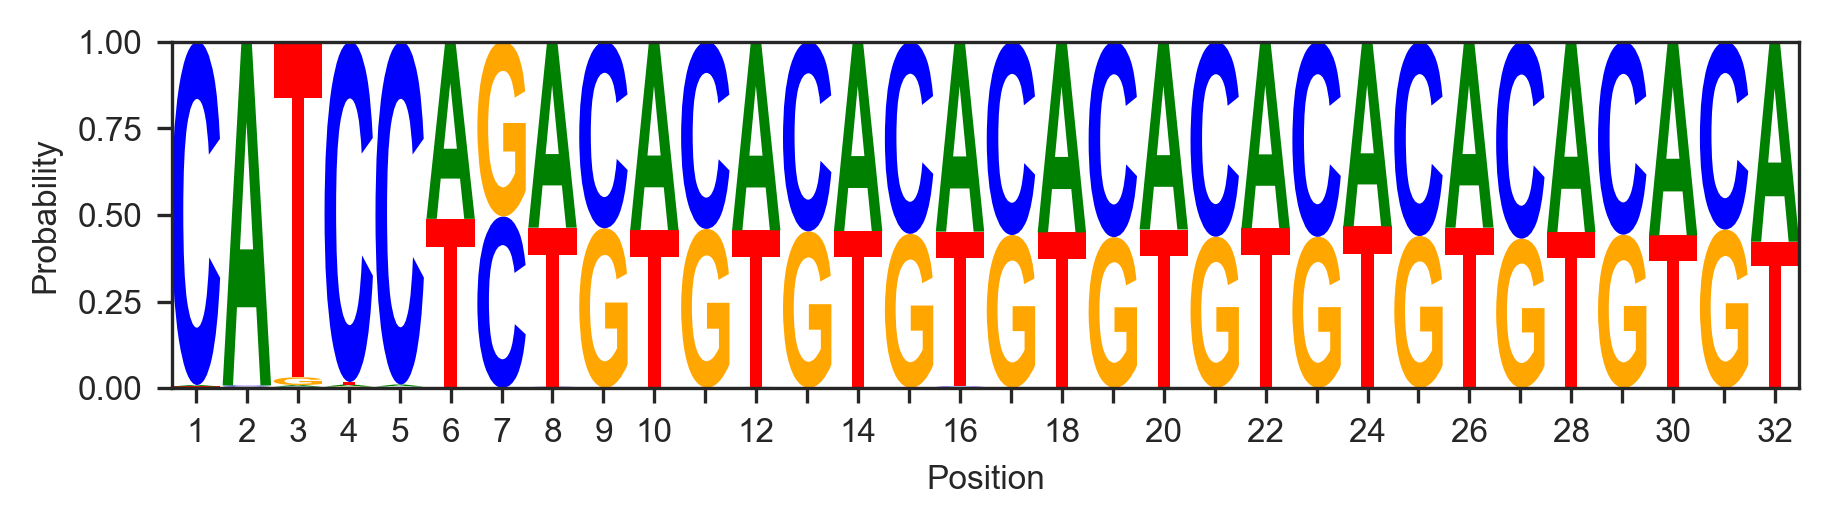

In [20]:
# Draw logo

fig, ax = plt.subplots(1, 1, figsize=(7,1.5))

logomaker.Logo(matrix, ax=ax)

ax.set_ylabel("Probability")
ax.set_xlabel("Position")

ax.set_xticks(np.arange(1,33))
ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, "", 12, "", 14, "", 16, "", 18, "", 20, "", 22, "", 24, "", 26, "", 28, "", 30, "", 32])

print()

# Plot barcode diversity

## Counts of unique barcodes

(0.4, 20.0)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


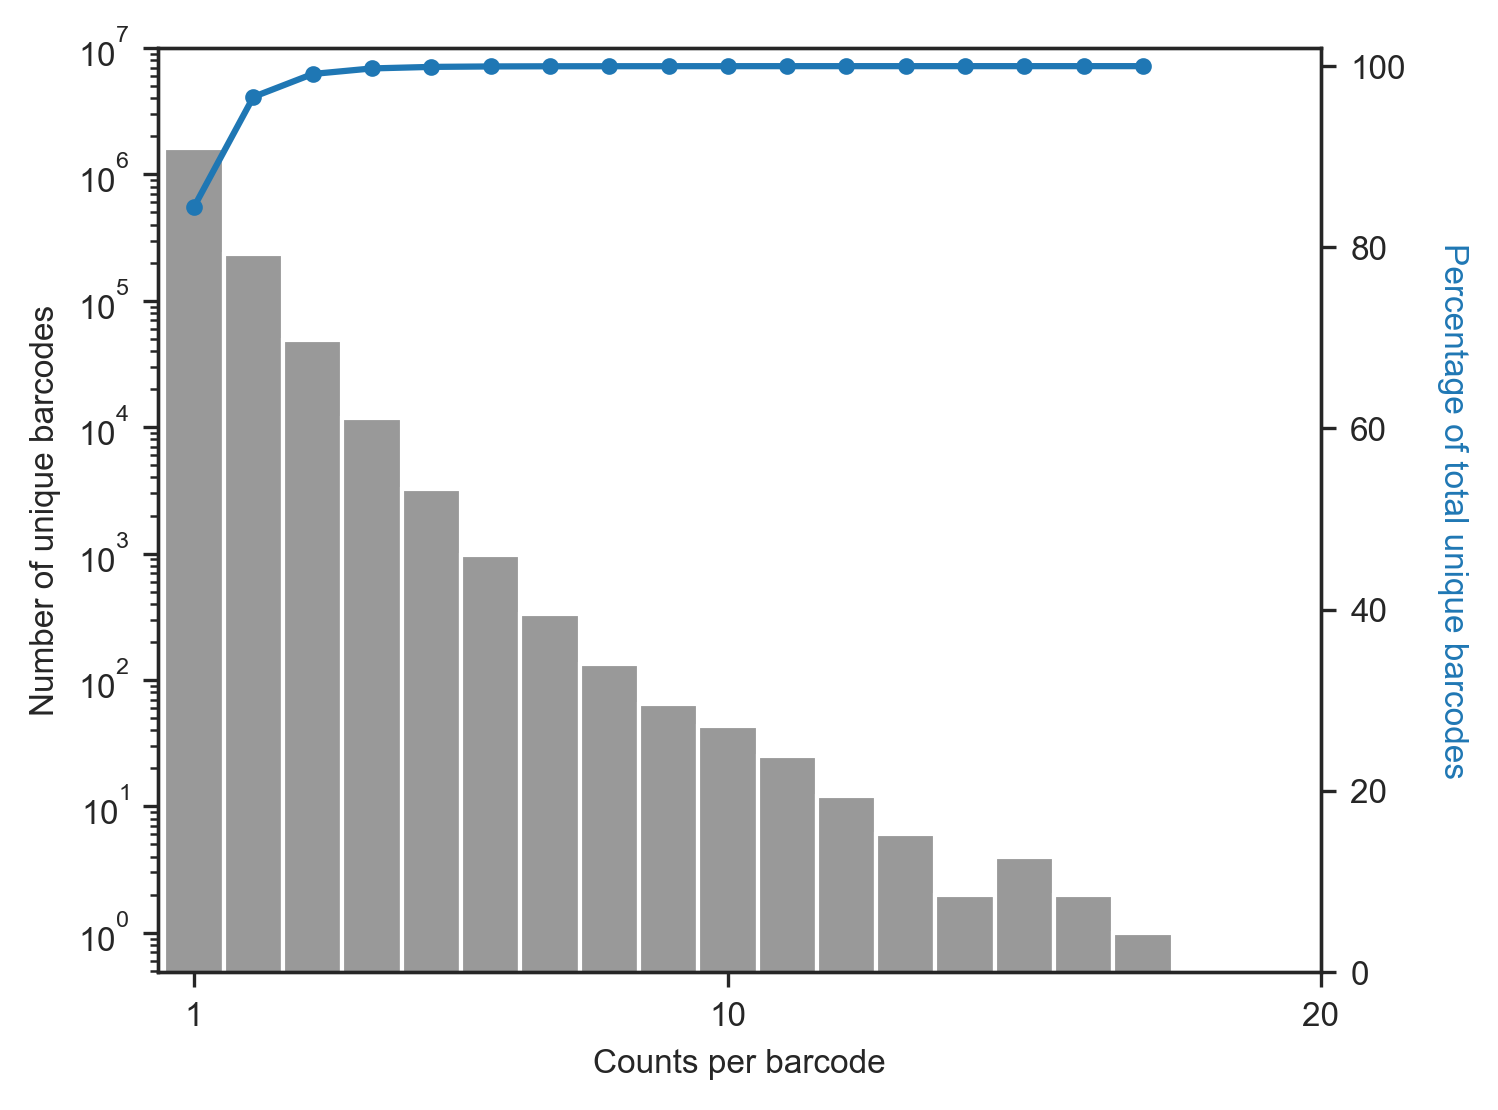

In [21]:
# Counts of unique barcodes

x = reads_clean_full.barcode.value_counts()  # get counts per unique barcode

bins = np.arange(1,max(x)+2) - 0.5  # choose bins to encompass every possible value
bin_centers = (bins[:-1] + bins[1:])/2  # get center of each bin

count, _ = np.histogram(x, bins=bins)  # get histogram counts
pdf = count / sum(count)  # find the PDF of the histogram using count values
cdf = np.cumsum(pdf)  # calculate CDF from PDF
cdf_percentage = cdf * 100  # convert CDF to percentage

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.hist(x, bins=bins, density=False, color="#999999")

ax.set_yscale("log")
ax.set_ylim(top=1e7)

ax2=ax.twinx()
ax2.plot(bin_centers, cdf_percentage, marker=".", color="#1f77b4")
ax2.yaxis.label.set_color("#1f77b4")

ax2.set_ylim(0, 102)

ax.set_xlabel("Counts per barcode")
ax.set_ylabel("Number of unique barcodes")
ax2.set_ylabel("Percentage of total unique barcodes", rotation=270, labelpad=15)

ax.set_xticks([1, 10, 20])
ax.set_xlim(left=0.4)

## Fraction of unique barcodes

(0.4, 20.0)

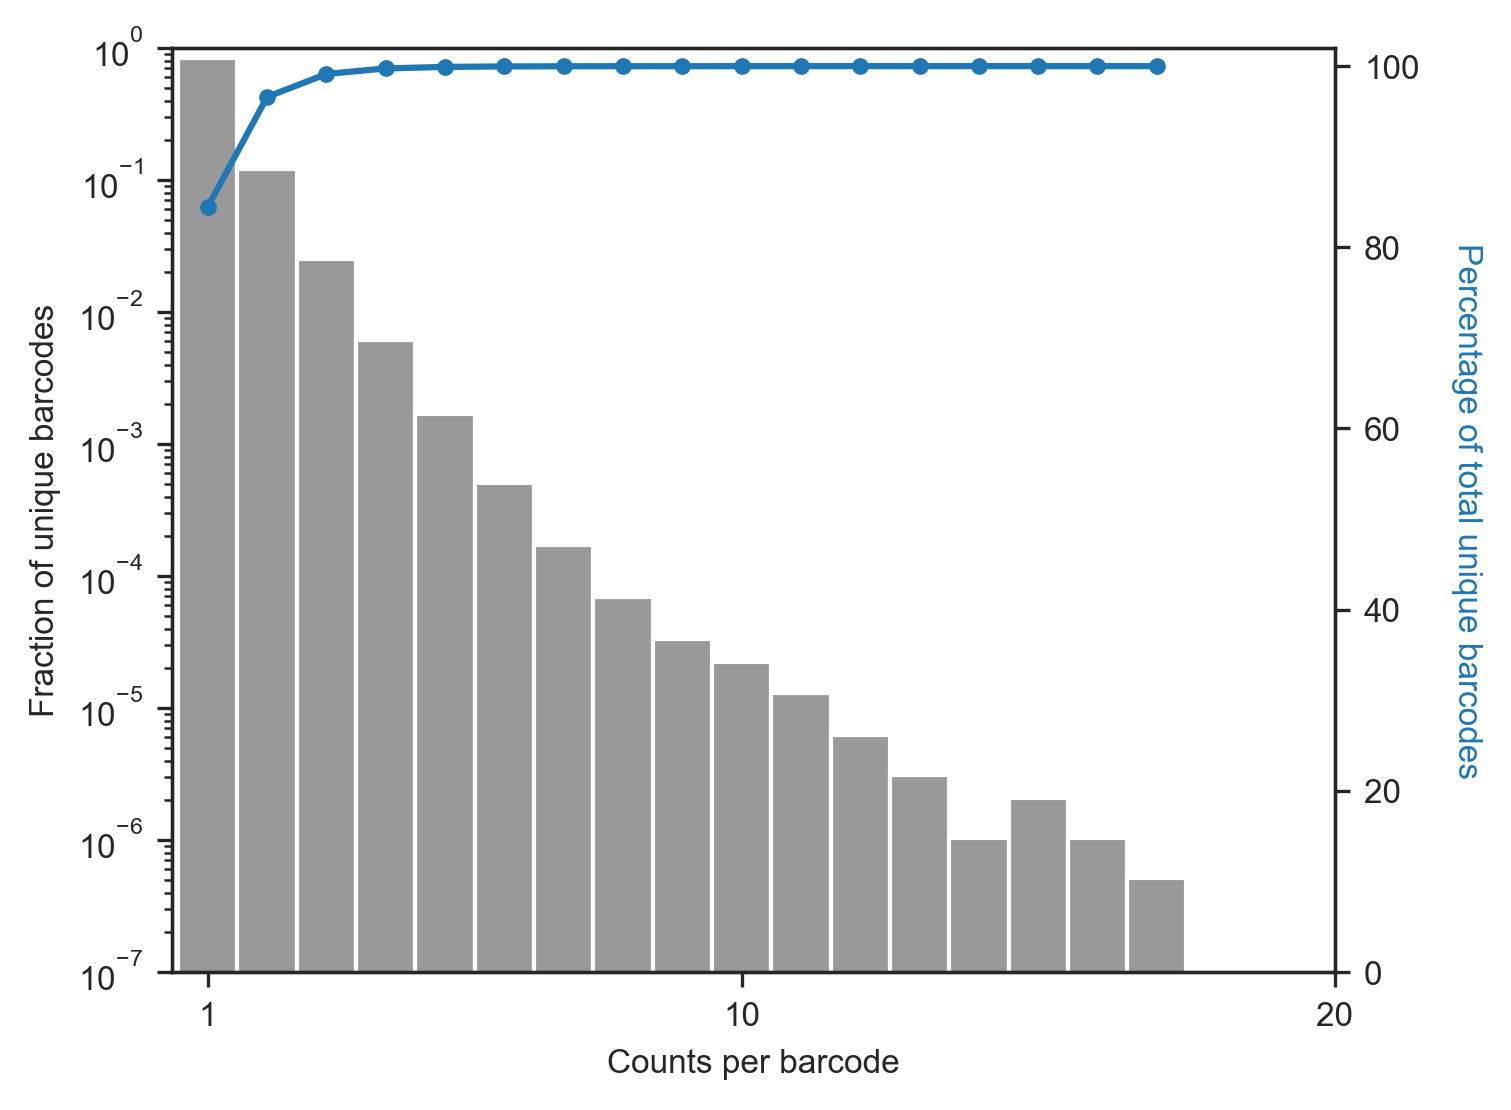

In [22]:
# Fraction of unique barcodes

x = reads_clean_full.barcode.value_counts()  # get counts per unique barcode

bins = np.arange(1,max(x)+2) - 0.5  # choose bins to encompass every possible value
bin_centers = (bins[:-1] + bins[1:])/2  # get center of each bin

count, _ = np.histogram(x, bins=bins)  # get histogram counts
pdf = count / sum(count)  # find the PDF of the histogram using count values
cdf = np.cumsum(pdf)  # calculate CDF from PDF
cdf_percentage = cdf * 100  # convert CDF to percentage

fig, ax = plt.subplots(1, 1, figsize=(5,4))

ax.hist(x, bins=bins, density=True, color="#999999")

ax.set_yscale("log")
ax.set_ylim(1e-7, 1)

ax2=ax.twinx()
ax2.plot(bin_centers, cdf_percentage, marker=".", color="#1f77b4")

ax2.set_ylim(0, 102)

ax.set_xlabel("Counts per barcode")
ax.set_ylabel("Fraction of unique barcodes")
ax2.set_ylabel("Percentage of total unique barcodes", rotation=270, labelpad=15)
ax2.yaxis.label.set_color("#1f77b4")

ax.set_xticks([1, 10, 20])
ax.set_xlim(left=0.4)

# Capture-recapture estimators of barcode diversity

In [23]:
# Define estimators

def chao1(counts):
    """ Chao1 estimator """
    F1 = sum(counts == 1)
    F2 = sum(counts == 2)
    Sobs = len(counts)
    S1 = Sobs + F1**2 / (2*F2)
    return S1

## Sample reads, count observed diversity, and calculate estimators

In [24]:
# Define parameters of sampling
depths = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # sampling depths (fraction of total reads)
n_rep = 10  # number of replicates at each depth

In [25]:
%%time

# Perform sampling, count diversity, and calculate estimators

depths_col = []
count_uniques = []
chao1_estimates = []

for depth in depths:
    
    for i in range(n_rep):
        
        sample1 = reads_clean_full.barcode.sample(frac=depth, random_state=i)
        sample2 = reads_clean_full.barcode.sample(frac=depth, random_state=i)
        
        counts = sample1.value_counts()
        
        count_unique = len(counts)  # unique barcodes observed
        
        chao1_estimate = chao1(counts)
        
        depths_col.append(depth)
        count_uniques.append(count_unique)
        chao1_estimates.append(chao1_estimate)
        
# Create dataframe
data = {"depth": depths_col,
        "count_unique": count_uniques,
        "chao1": chao1_estimates}
diversity_subsampled = pd.DataFrame(data=data)

print(diversity_subsampled.shape)
diversity_subsampled.head()

(100, 3)
CPU times: user 3min 7s, sys: 538 ms, total: 3min 8s
Wall time: 3min 7s


,depth,count_unique,chao1
0,0.1,226886,5.399691e+06
1,0.1,227043,5.583017e+06
2,0.1,227036,5.593193e+06
3,0.1,227114,5.638442e+06
4,0.1,227029,5.577351e+06


In [26]:
# Summarize replicates
diversity_subsampled_summary = diversity_subsampled.groupby("depth").mean()
diversity_subsampled_summary = diversity_subsampled_summary.reset_index()
diversity_subsampled_summary

,depth,count_unique,chao1
0,0.1,227005.3,5.536900e+06
1,0.2,444673.1,5.819025e+06
2,0.3,653839.1,6.082050e+06
3,0.4,855219.4,6.333074e+06
4,0.5,1049411.5,6.567537e+06
5,0.6,1237039.3,6.791050e+06
6,0.7,1418598.1,7.011862e+06
7,0.8,1594332.3,7.217604e+06
8,0.9,1764774.7,7.414831e+06
9,1.0,1930166.0,7.607711e+06


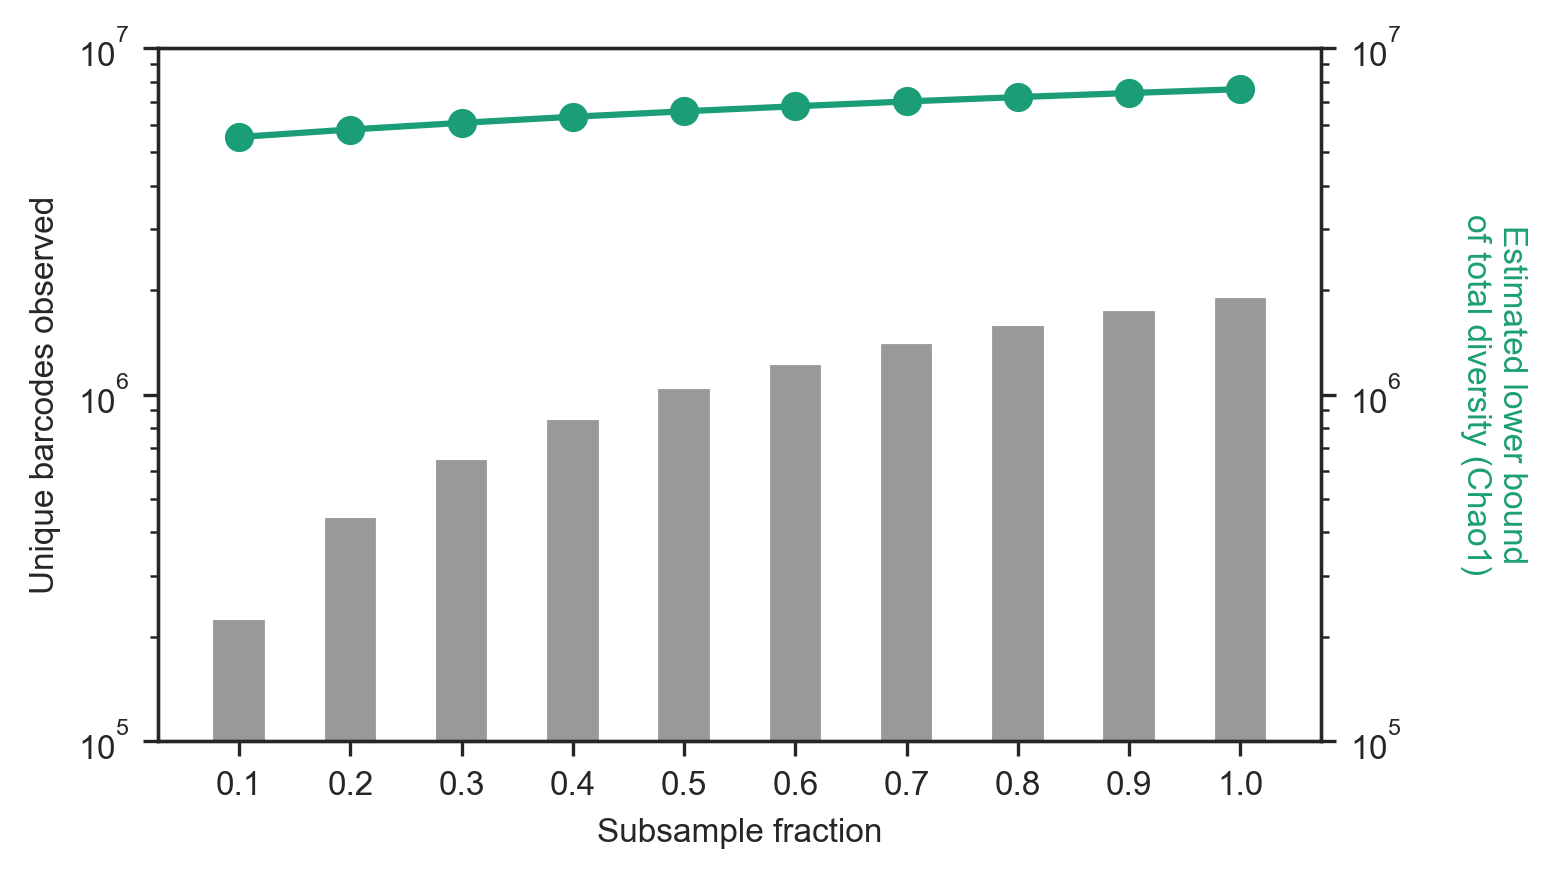

In [27]:
# Plot

fig, ax = plt.subplots(1, 1, figsize=(5,3))

width = 0.05
ax.bar(diversity_subsampled_summary["depth"],
       diversity_subsampled_summary["count_unique"],
       width=width,
       align="center",
       color="#999999")

ax.set_yscale("log")
ax.set_ylim(1e5, 1e7)

ax2=ax.twinx()

ax2.plot(diversity_subsampled_summary["depth"],
         diversity_subsampled_summary["chao1"],
         marker="o", color="#1b9e77", 
         label="Chao1",
         zorder=3)

ax2.set_yscale("log")
ax2.set_ylim(1e5, 1e7)
ax.set_xlabel("Subsample fraction")
ax.set_ylabel("Unique barcodes observed")
ax2.set_ylabel("Estimated lower bound\nof total diversity (Chao1)", rotation=270, labelpad=30)
ax2.yaxis.label.set_color("#1b9e77")

xticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ax.set_xticks(xticks)

In [28]:
# Report diversity estimate from full sample
diversity_subsampled_summary.loc[diversity_subsampled_summary["depth"] == 1]

,depth,count_unique,chao1
9,1.0,1930166.0,7.607711e+06


# Collision probability

Estimate collision probability (cells at start of experiment which share a barcode due to coincidence of independent barcoding events, rather than common clonal origin).

In [29]:
# Define parameters of sampling
N_cells = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]  # number of cells (equivalent to number of barcodes to sample)
n_rep = 100  # number of replicates at each depth

In [30]:
%%time

# Perform sampling, calculate fraction of unique barcodes

n_cells_col = []
frac_uniques = []

for n_cells in N_cells:

    for i in range(n_rep):

        sample = reads_clean_full.barcode.sample(n=n_cells, random_state=i)
    
        counts = sample.value_counts()  # calculate number of times each barcode is observed
        frac_unique = np.mean(counts == 1)  # calculate fraction of barcodes that are unique
        
        n_cells_col.append(n_cells)
        frac_uniques.append(frac_unique)

# Create dataframe
data = {"n_cells": n_cells_col,
        "frac_unique": frac_uniques}
collision_sampled = pd.DataFrame(data=data)

print(collision_sampled.shape)
collision_sampled.head()

(1000, 2)
CPU times: user 59 s, sys: 127 ms, total: 59.1 s
Wall time: 59.1 s


,n_cells,frac_unique
0,100,1.0
1,100,1.0
2,100,1.0
3,100,1.0
4,100,1.0


In [31]:
# Summarize replicates
collision_sampled_summary = collision_sampled.groupby("n_cells").mean()  # mean of replicates
collision_sampled_summary["sem_frac_unique"] = collision_sampled.groupby("n_cells").sem()["frac_unique"]  # SEM of replicates
collision_sampled_summary["std_frac_unique"] = collision_sampled.groupby("n_cells").std()["frac_unique"]  # SD of replicates
collision_sampled_summary = collision_sampled_summary.reset_index()
collision_sampled_summary

,n_cells,frac_unique,sem_frac_unique,std_frac_unique
0,100,1.000000,0.000000,0.000000
1,200,0.999950,0.000050,0.000503
2,500,0.999980,0.000020,0.000200
3,1000,0.999910,0.000029,0.000288
4,2000,0.999770,0.000032,0.000321
5,5000,0.999496,0.000034,0.000336
6,10000,0.999043,0.000031,0.000309
7,20000,0.998039,0.000034,0.000335
8,50000,0.995174,0.000030,0.000297
9,100000,0.990541,0.000031,0.000308


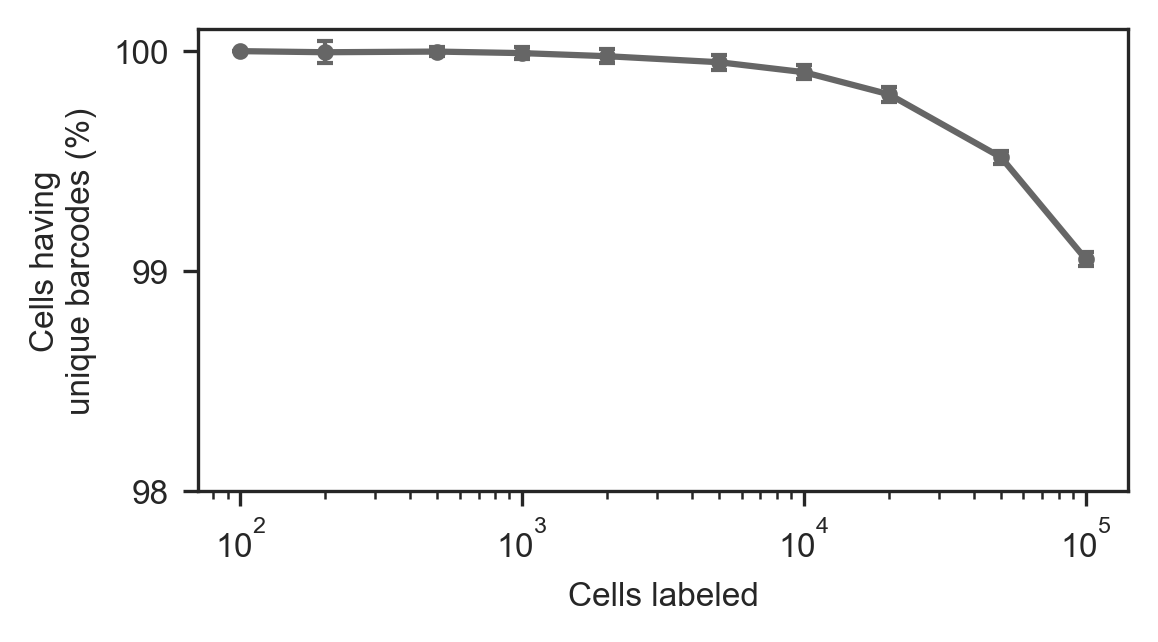

In [32]:
# Plot

fig, ax = plt.subplots(1, 1, figsize=(4,2))

ax.errorbar(collision_sampled_summary["n_cells"],
            collision_sampled_summary["frac_unique"]*100,
            yerr=collision_sampled_summary["std_frac_unique"]*100,
            capsize=2, elinewidth=1,
            marker=".", color="#666666")

# errorbars are smaller than markers

ax.set_xscale("log")
ax.set_ylim(98, 100.1)

ax.set_xlabel("Cells labeled")
ax.set_ylabel("Cells having\nunique barcodes (%)")

yticks = [98, 99, 100]
ax.set_yticks(yticks)

# Write outputs to file

Write key dataframes for plots to output files. We load these data from several viral libraries in another notebook, so we can plot them together on single plots.

In [33]:
%%time

x = reads_clean_full.barcode.value_counts()  # get counts per unique barcode

outfile = output_dir + "/reads_clean_full_barcode_counts.tsv"

x.to_csv(outfile, sep="\t")

CPU times: user 4.1 s, sys: 160 ms, total: 4.26 s
Wall time: 4.48 s


In [34]:
%%time

outfile = output_dir + "/diversity_subsampled_summary.tsv"

diversity_subsampled_summary.to_csv(outfile, sep="\t")

CPU times: user 3.28 ms, sys: 0 ns, total: 3.28 ms
Wall time: 2.51 ms


In [35]:
%%time

outfile = output_dir + "/collision_sampled_summary.tsv"

collision_sampled_summary.to_csv(outfile, sep="\t")

CPU times: user 0 ns, sys: 1.86 ms, total: 1.86 ms
Wall time: 1.37 ms


# Conclusions and Next Steps